In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from whereswitch import whereswitch, multiwhereswitch
from astropy.coordinates import SkyCoord
from astropy import units as u

What this code does:

1. Load data files
2. Compute gas masses of galaxies
3. Compute stellar masses of galaxies
4. Compute halo virulent masses of galaxies
5. Compute the gas and disk fractions of galaxies
6. Add galaxy positions and radial velocities to the results
7. Compute distance of each galaxy from centre
8. Save table of results to fixed-width txt file

# 1. Load data files

In [2]:
# load data from Hill papers into pandas.DataFrame objects
# set index to be the (C1, C3, C6, ...) labels
df_Hill_2020 = pandas.read_fwf('data_from_papers/Hill_2020.csv').set_index('label')
df_Hill_2020_positions = pandas.read_fwf('data_from_papers/Hill_2020_positions.csv').set_index('label')
df_Hill_2021 = pandas.read_fwf('data_from_papers/Hill_2021.csv').set_index('label')
df_Rotermund_2021 = pandas.read_fwf('data_from_papers/Rotermund_2021.csv').set_index('label')
df_Apostolovski = pandas.read_fwf('data_from_papers/Apostolovski.csv').set_index('label')
df_Nik = pandas.read_fwf('data_from_papers/Nik.csv').set_index('label')

In [3]:
# construct a dictionary mapping from the old lettered
# labels (A, B, C, ...) to the new Cx labels (C1, C3, C6, ...)
# uses contents of Hill_2020.csv file
label_map = {k:v for v,k in df_Hill_2020['label2'][~df_Hill_2020['label2'].isna()].iteritems()}
label_map

{'A': 'C1',
 'J': 'C2',
 'B': 'C3',
 'D': 'C4',
 'F': 'C5',
 'C': 'C6',
 'K': 'C7',
 'E': 'C8',
 'I': 'C9',
 'H': 'C10',
 'L': 'C11',
 'G': 'C13',
 'N': 'C14',
 'M': 'C17'}

In [4]:
# load data from Miller paper into pandas.DataFrame object
df_Miller_2018 = pandas.read_fwf('data_from_papers/Miller_2018.csv')
# add a new column to the Miller data with the new (C1, C3, C6, ...) labels
df_Miller_2018['label'] = df_Miller_2018['label2'].map(label_map)
# set the index of the Miller DataFrame to be the (C1, C3, C6, ...) labels
df_Miller_2018 = df_Miller_2018.set_index('label')

In [5]:
# combine all the data into a single pandas.DataFrame object
# nested column names segregate based on data source
# e.g. df_Miller_2018 becomes df['Miller_2018']
#      df_Miller_2018['Mgas'] becomes df['Miller_2018', 'Mgas']
df = pandas.concat(
    (
        pandas.concat((df_Hill_2020, df_Hill_2020_positions), axis=1),
        df_Hill_2021, df_Miller_2018, df_Rotermund_2021, df_Apostolovski, df_Nik
    ),
    keys=('Hill_2020', 'Hill_2021', 'Miller_2018', 'Rotermund_2021', 'Apostolovski', 'Nik'),
    axis=1)

In [6]:
# check that all of the old labels (A, B, C, ...) line up in the data from each paper
assert(all(df['Hill_2020', 'label2'].isna() | (df['Hill_2020', 'label2'] == df['Hill_2021', 'label2']) & (df['Hill_2020', 'label2'] == df['Miller_2018', 'label2'])))

# df.loc[:,[('Hill_2020', 'label2'), ('Hill_2021', 'label2'), ('Miller_2018', 'label2')]]

In [7]:
# add a column to the Hill_2020 data with the method used for computing gas estimates
# all values Hill reported were computed using the CO34 method
# method: https://stackoverflow.com/questions/67477744/pandas-numpy-where-and-numpy-nan/
df['Hill_2020', 'method'] = np.where(df['Hill_2020', 'Mgas'].notna(), 'CO43', None)
df['Hill_2020', 'method'].fillna(np.nan, inplace=True) # convert None to NaN

In [8]:
# compute percent uncertainties, add as columns to df
df['Hill_2020', 'pu_Mdyn'] = df['Hill_2020', 'u_Mdyn'] / df['Hill_2020', 'Mdyn']
df['Hill_2020', 'pu_Mgas'] = df['Hill_2020', 'u_Mgas'] / df['Hill_2020', 'Mgas']
df['Hill_2021', 'pu_M*'] = df['Hill_2021', 'u_M*'] / df['Hill_2021', 'M*']
df['Hill_2020', 'pu_FCO43'] = df['Hill_2020', 'u_FCO43'] / df['Hill_2020', 'FCO43']
df['Hill_2020', 'pu_FCii'] = df['Hill_2020', 'u_FCii'] / df['Hill_2020', 'FCii']
df['Miller_2018', 'pu_Mgas'] = df['Hill_2020', 'u_Mgas'] / df['Miller_2018', 'Mgas']

In [9]:
# compute ratio of Miller's Mgas to Hill's Mgas, add as a column to df
df['derived', 'Miller/Hill'] = df['Miller_2018', 'Mgas'] / df['Hill_2020', 'Mgas']

In [10]:
# let's look at what we've got
df

Hill_2020                                                        \
             label2  Mdyn u_Mdyn  Mgas u_Mgas   FCii u_FCii FCO43 u_FCO43   
label                                                                       
C1                A  27.0    1.1   7.5    0.7  16.86   0.20  0.98    0.03   
C2                J   6.9    0.3   2.1    0.2   8.82   0.13  0.27    0.02   
C3                B   9.9    1.0   4.3    0.4   7.89   0.12  0.56    0.02   
C4                D  13.8    1.7   3.0    0.3   5.90   0.15  0.38    0.02   
C5                F  18.0    1.5   1.1    0.2   5.19   0.15  0.14    0.02   
C6                C   3.7    0.2   3.4    0.3   5.16   0.07  0.44    0.02   
C7                K   3.6    1.4   1.0    0.1   3.76   0.09  0.13    0.01   
C8                E   2.1    0.2   2.4    0.3   3.68   0.12  0.31    0.02   
C9                I  10.8    0.8   0.9    0.1   3.35   0.11  0.12    0.02   
C10               H   3.6    0.4   1.1    0.2   2.96   0.10  0.14    0.02   
C11               L   3.7    0.3   0.3    0.1   2.70   0.11  0.04    0.01   
C12             NaN   3.0    1.2   NaN    NaN   2.62   0.09   NaN     NaN   
C13               G   3.1    0.9   0.8    0.1   1.84   0.08  0.10    0.01   
C14               N   2.1    0.9   0.2    0.1   1.70   0.08  0.03    0.01   
C15             NaN   4.2    1.7   NaN    NaN   1.65   0.09   NaN     NaN   
C16             NaN   2.2    1.2   NaN    NaN   1.11   0.06   NaN     NaN   
C17               M   1.3    0.6   NaN    NaN   0.93   0.09   NaN     NaN   
C18             NaN   3.7    1.6   NaN    NaN   0.86   0.09   NaN     NaN   
C19             NaN   1.4    0.6   NaN    NaN   0.85   0.07   NaN     NaN   
C20             NaN   1.1    0.5   NaN    NaN   0.51   0.06   NaN     NaN   
C21             NaN   0.9    0.4   NaN    NaN   0.35   0.04   NaN     NaN   
C22             NaN   0.2    0.1   NaN    NaN   0.33   0.03   NaN     NaN   
C23             NaN   0.5    0.2   NaN    NaN   0.28   0.03   NaN     NaN   
NL1             NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
NL3             NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
N1              NaN  16.2    6.5  12.0    1.0  18.87   0.20  1.55    0.03   
N2              NaN  18.7    8.5   5.0    0.5    NaN    NaN  0.65    0.04   
N3              NaN   6.5    3.3   0.9    0.2    NaN    NaN  0.12    0.02   
NL2             NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
SPIREc1         NaN   7.9    3.5   5.5    0.6    NaN    NaN  0.72    0.05   
SPIREc2         NaN  12.3    7.2   2.9    0.5    NaN    NaN  0.37    0.05   
SPIREc3         NaN   4.6    2.2   1.9    0.3    NaN    NaN  0.25    0.04   
LBG3            NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LBG2            NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LAE-ID72        NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LAE-ID21        NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LAE-ID56        NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LAE-ID109       NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LAE-ID74        NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LAE-ID91        NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
LAE-ID118       NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
A-north         NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
A-south         NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
N-west          NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
South5          NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
E-south         NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   
F-east          NaN   NaN    NaN   NaN    NaN    NaN    NaN   NaN     NaN   

                   ...    Nik       Hill_2020                     Hill_2021  \
              SFR  ...      v   u_v    method   pu_Mdyn   pu_Mgas     pu_M*   
l

# 2. Gas masses

## 2.1 Galaxies detected by ALMA (Miller 2018, Hill 2020)

### Boost Hill's gas masses to agree with Miller's gas masses

Hill's gas masses are likely underestimates since Hill chose $\alpha_{CO} = 1$ (p. 13). Instead, $\alpha_{CO}$ is probably around 2 or 3. We boost all of Hill's gas estimates by a common factor to correct for this.

To estimate the boost factor, we take the mean ratio of Miller's data to Hill's data. When computing this boost factor, we only consider galaxies for which we have good mass estimates from Hill and Miller based on $CO_{3-4}$ emission (as opposed to the less-reliable $[C\,II]$ method).

In [11]:
# find indeces in df where both Miller's and Hill's gas mass estimates were computed from CO34 emission
indices_Mill_Hill_CO = (df['Miller_2018', 'method'] == 'CO43') & (df['Hill_2020', 'method'] == 'CO43')
# find mean ratio of Miller's gas masses to Hill's, for these galaxies
Miller_Hill_ratio = df.loc[indices_Mill_Hill_CO, ('derived', 'Miller/Hill')].mean()
print('Miller_Hill_ratio:', Miller_Hill_ratio)

Miller_Hill_ratio: 2.1947764976321746


In [12]:
# add a new column to df that is Hill's gas measurements, but boosted by this factor
df['Hill_2020', 'Mgas_boosted'] = df['Hill_2020', 'Mgas'] * Miller_Hill_ratio

### Estimate gas masses based on Hill's Cii when CO43 flux is too weak

Hill (2020) calculated gas masses based on the measured $CO_{3-4}$ flux FCO43, but sometimes this flux was too weak to get a good result. We can estimate what the gas mass should have been by:
1. Coming up with a scaling factor relating the $[C\,II]$ flux FCii and the $CO_{3-4}$ flux FCO43.
2. Using the scaling factor to estimate what the $CO_{3-4}$ flux should have been based on the $[C\,II]$ flux.
3. Estimating the gas mass using the scaling factor that relates gas mass to $CO_{3-4}$ flux.

Notes:
* We want to compute what the gas estimate should be *after* we have applied the boost above.
* We could just take the $CO_{3-4}$ to $M_{gas}$ from Hill's paper, but it is more convenient to just compute it using values in the table.

In [13]:
# find the indices where Hill had sufficient CO43 flux to estimate gas mass
indices_Hill_CO43 = df['Hill_2020', 'method'] == 'CO43'

# add column of ratio of CO43 flux to Cii flux
# leave values as NaN if CO43 flux was too small to estimate gas mass
df['Hill_2020', 'CO43/Cii'] = np.where(indices_Hill_CO43, 
                                       df['Hill_2020', 'FCO43'] / df['Hill_2020', 'FCii'],
                                       np.nan)
# compute mean ratio for galaxies where CO43 flux was large enough to compute gas mass
ratio_CO43_Cii = df['Hill_2020', 'CO43/Cii'].mean()
print(ratio_CO43_Cii)

# add column of ratio of Mgas to CO43 flux
# leave values as NaN if CO43 flux was too small to estimate gas mass
df['Hill_2020', 'Mgas/CO43'] = np.where(indices_Hill_CO43, 
                                       df['Hill_2020', 'Mgas'] / df['Hill_2020', 'FCO43'],
                                       np.nan)
# compute mean ratio for galaxies where CO43 flux was large enough to compute gas mass
ratio_Mgas_CO43 = df['Hill_2020', 'Mgas/CO43'].mean()
print(ratio_Mgas_CO43)

# add columns of Mgas estimates based on Cii
df['Hill_2020', 'Mgas_Cii'] = Miller_Hill_ratio * ratio_Mgas_CO43 * ratio_CO43_Cii * df['Hill_2020', 'FCii']
df['Nik', 'Mgas_Cii'] = ratio_Mgas_CO43 * ratio_CO43_Cii * df['Nik', 'FCii']
# observe that we also apply the boost from above, to bring in line with Miller's values

print(ratio_CO43_Cii * ratio_Mgas_CO43)


0.05051781500443459
7.660925550539654
0.38701321972490843


Text(0, 0.5, 'Ratio of gas mass to CO43 flux')

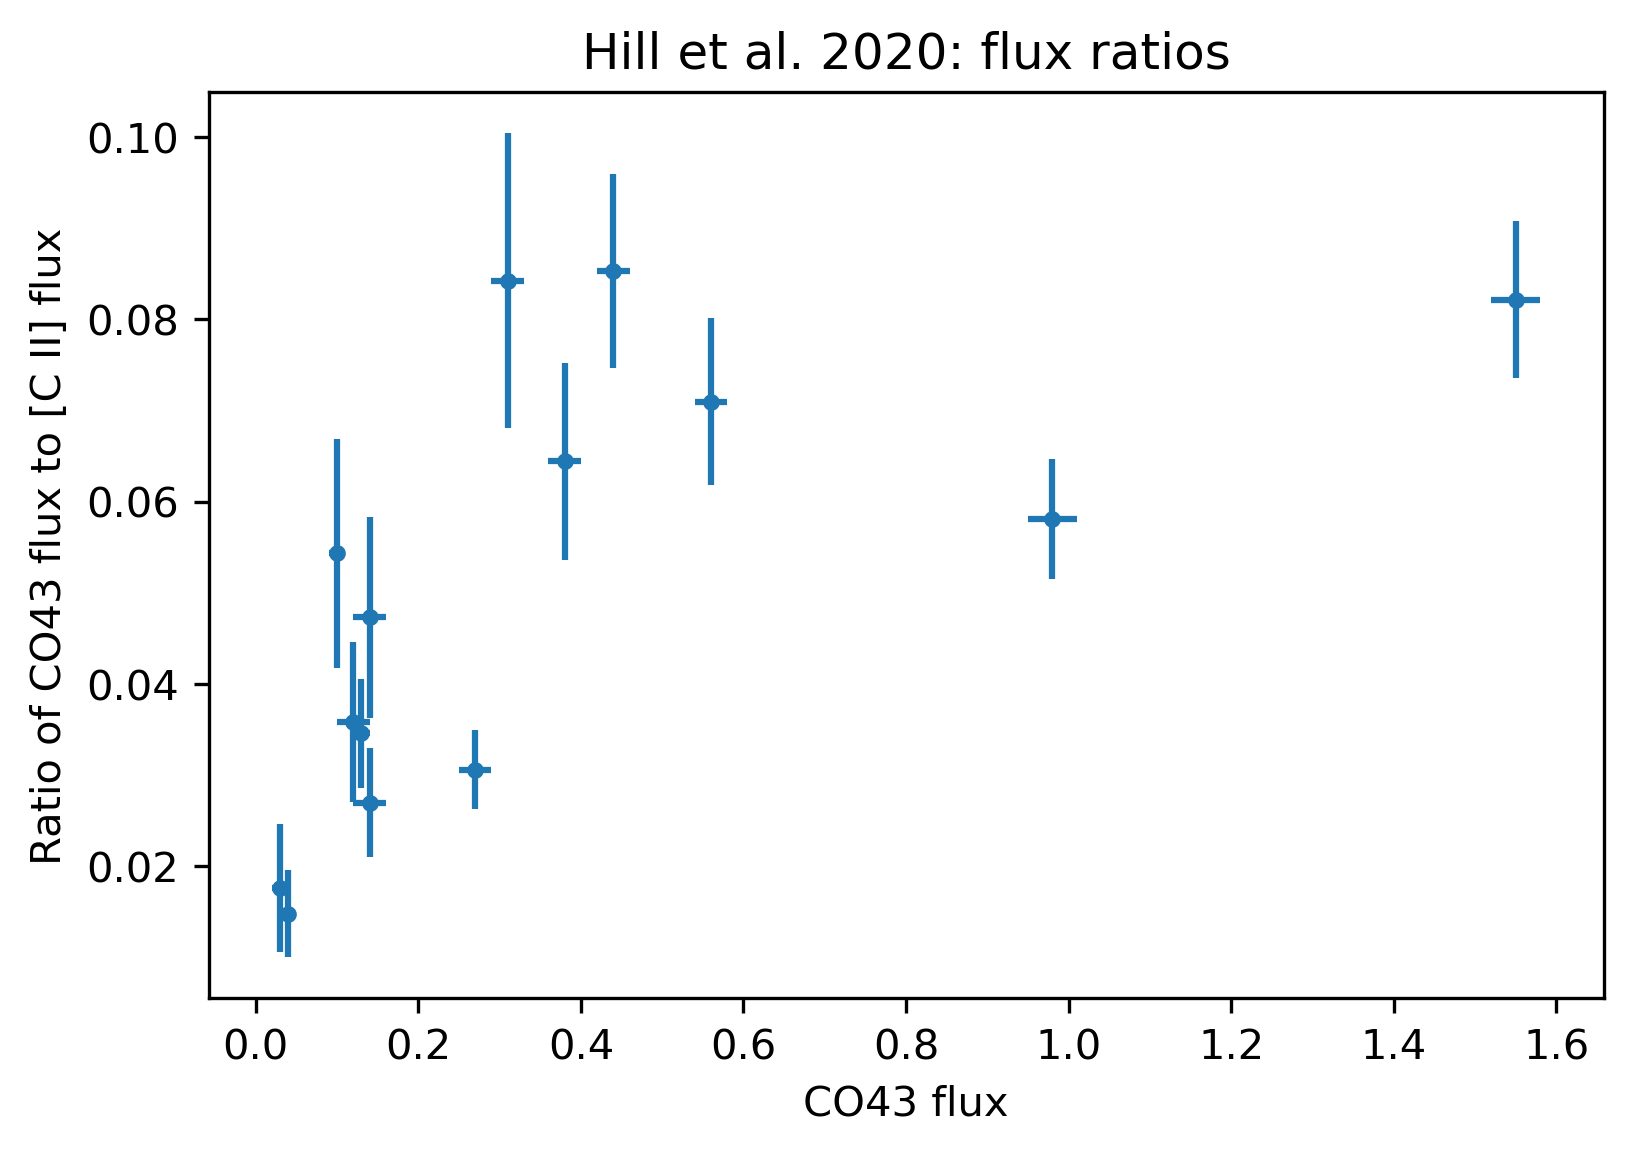

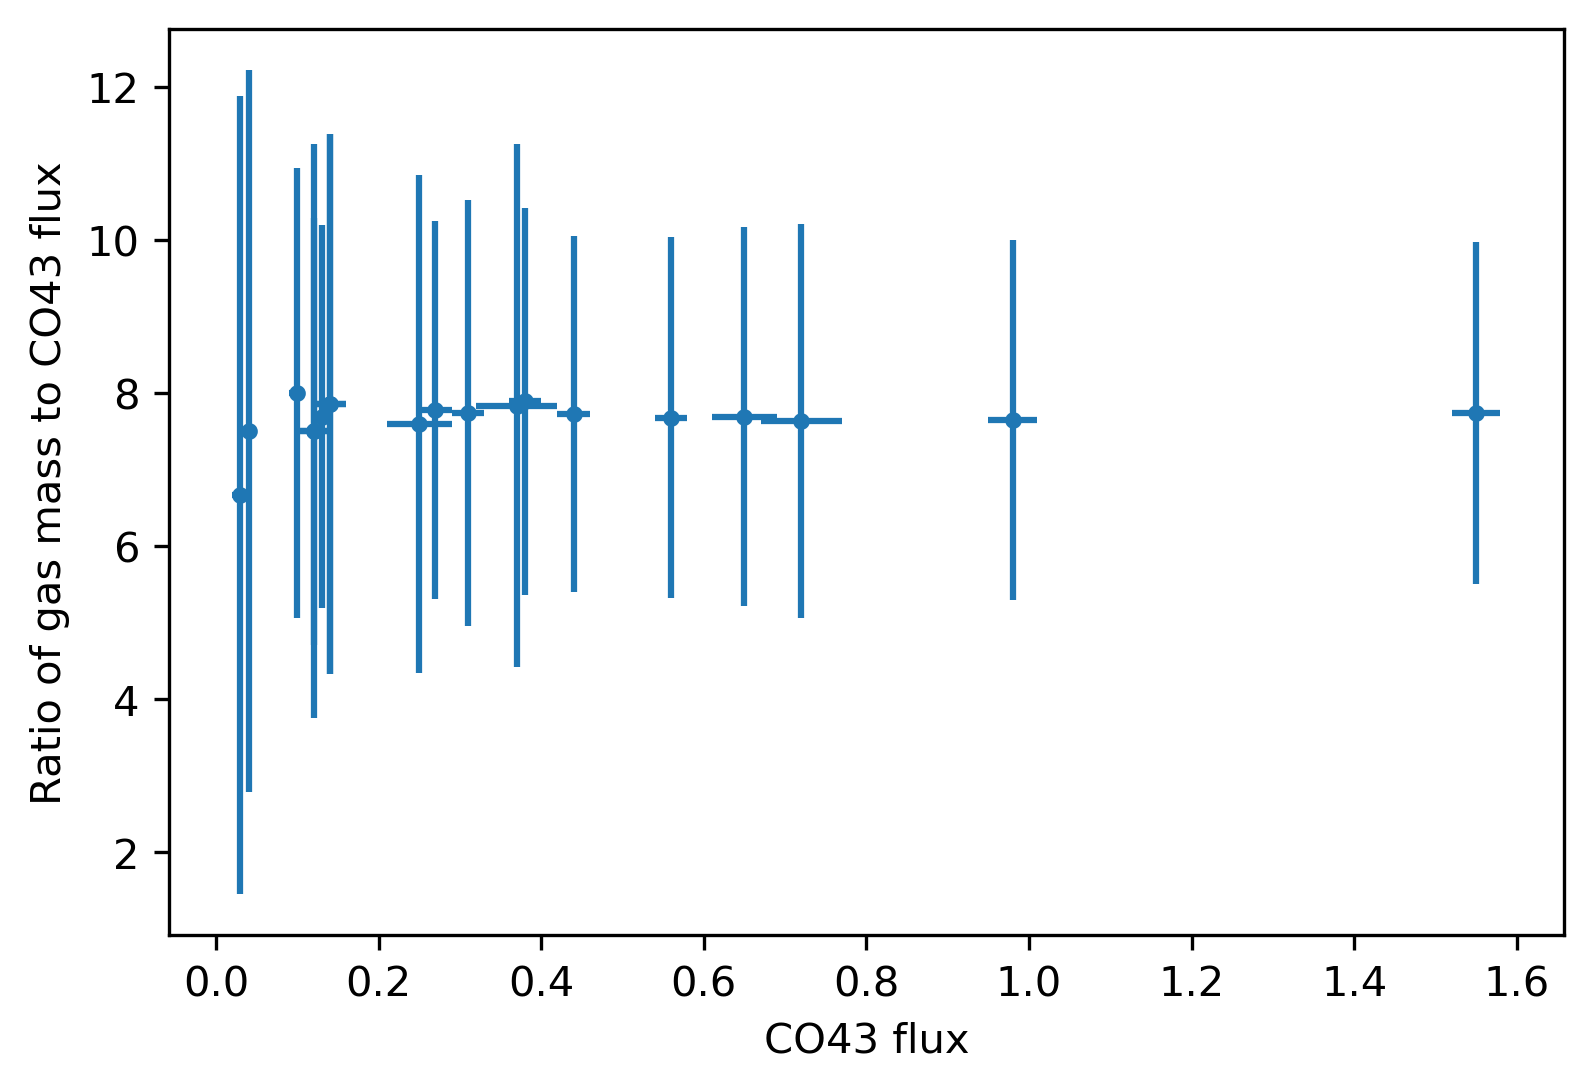

In [14]:
plt.figure(dpi=300)
plt.errorbar(
    df['Hill_2020', 'FCO43'],
    df['Hill_2020', 'CO43/Cii'],
    xerr=df['Hill_2020', 'u_FCO43'],
    yerr = df['Hill_2020', 'CO43/Cii'] * np.sqrt(df['Hill_2020', 'pu_FCO43']**2 + df['Hill_2020', 'pu_FCii']),
    linestyle='',
    marker='.'
)
plt.xlabel('CO43 flux')
plt.ylabel('Ratio of CO43 flux to [C II] flux')
plt.title('Hill et al. 2020: flux ratios')

plt.figure(dpi=300)
plt.errorbar(
    df['Hill_2020', 'FCO43'],
    df['Hill_2020', 'Mgas/CO43'],
    xerr=df['Hill_2020', 'u_FCO43'],
    yerr = df['Hill_2020', 'Mgas/CO43'] * np.sqrt(df['Hill_2020', 'pu_FCO43']**2 + df['Hill_2020', 'pu_Mgas']),
    linestyle='',
    marker='.'
)
plt.xlabel('CO43 flux')
plt.ylabel('Ratio of gas mass to CO43 flux')


### Choose "final" gas mass

For the simulation gas masses, we will use the boosted Hill estimates as these are considered more reliable than Miller's. We will use CO43 where available and Cii otherwise.

In [15]:
# create columns for the chosen gass mass, a description of the method, and the source of data
df['final', 'Mgas'], df['final', 'Mgas_method'], df['final', 'Mgas_source'] = multiwhereswitch(
    # condition: Hill estimated gas mass using CO43
    df['Hill_2020', 'method'] == 'CO43',
    [ # result for this condition
        df['Hill_2020', 'Mgas_boosted'], # gas mass
        'CO43', # method
        'Hill_2020' # source
    ],
    # condition: we have a gas mass estimate using Cii (Hill)
    df['Hill_2020', 'Mgas_Cii'].notna(),
    [ # result for this condition
        df['Hill_2020', 'Mgas_Cii'], # gas mass
        'Cii', # method
        'Hill_2020' # source
    ],
    # condition: we have a gas mass estimate using Cii (Nik)
    df['Nik', 'Mgas_Cii'].notna(),
    [ # result for this condition
        df['Nik', 'Mgas_Cii'], # gas mass
        'Cii', # method
        'Nik' # source
    ],
    
    force_object=[False, True, True] # we set to True for columns containing strings
)
# let's look at what we've got
df['final']

,Mgas,Mgas_method,Mgas_source
label,,,
C1,16.460824,CO43,Hill_2020
C2,4.609031,CO43,Hill_2020
C3,9.437539,CO43,Hill_2020
C4,6.584329,CO43,Hill_2020
C5,2.414254,CO43,Hill_2020
C6,7.462240,CO43,Hill_2020
C7,2.194776,CO43,Hill_2020
C8,5.267464,CO43,Hill_2020
C9,1.975299,CO43,Hill_2020


## 2.2 LAEs and LBGs (Apostolovski, Roterm)

For the LAEs and LBGs, our only useful measurements are the star formation rates (SFR). We'll scale the SFRs to gas masses using the data from Hill (2020). This is very rough, though, as you can see in the histograms. It's good enough for us, though, and it gives approximations that should be good within an order of magnitude or so.

### Determine scale factor between SFR and gas mass

In [16]:
# galaxies to use when developing SFR-gas mass scale factor from Hill 2020
# we exclude those with lots of uncertainty in SFR
SFR_gas_include = [
    'C1', 'C2', 'C3', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C13'
]

In [17]:
df['derived', 'Mgas/SFR'] = df['final', 'Mgas'] / df['Hill_2020', 'SFR']
x = df['derived', 'Mgas/SFR'][SFR_gas_include]

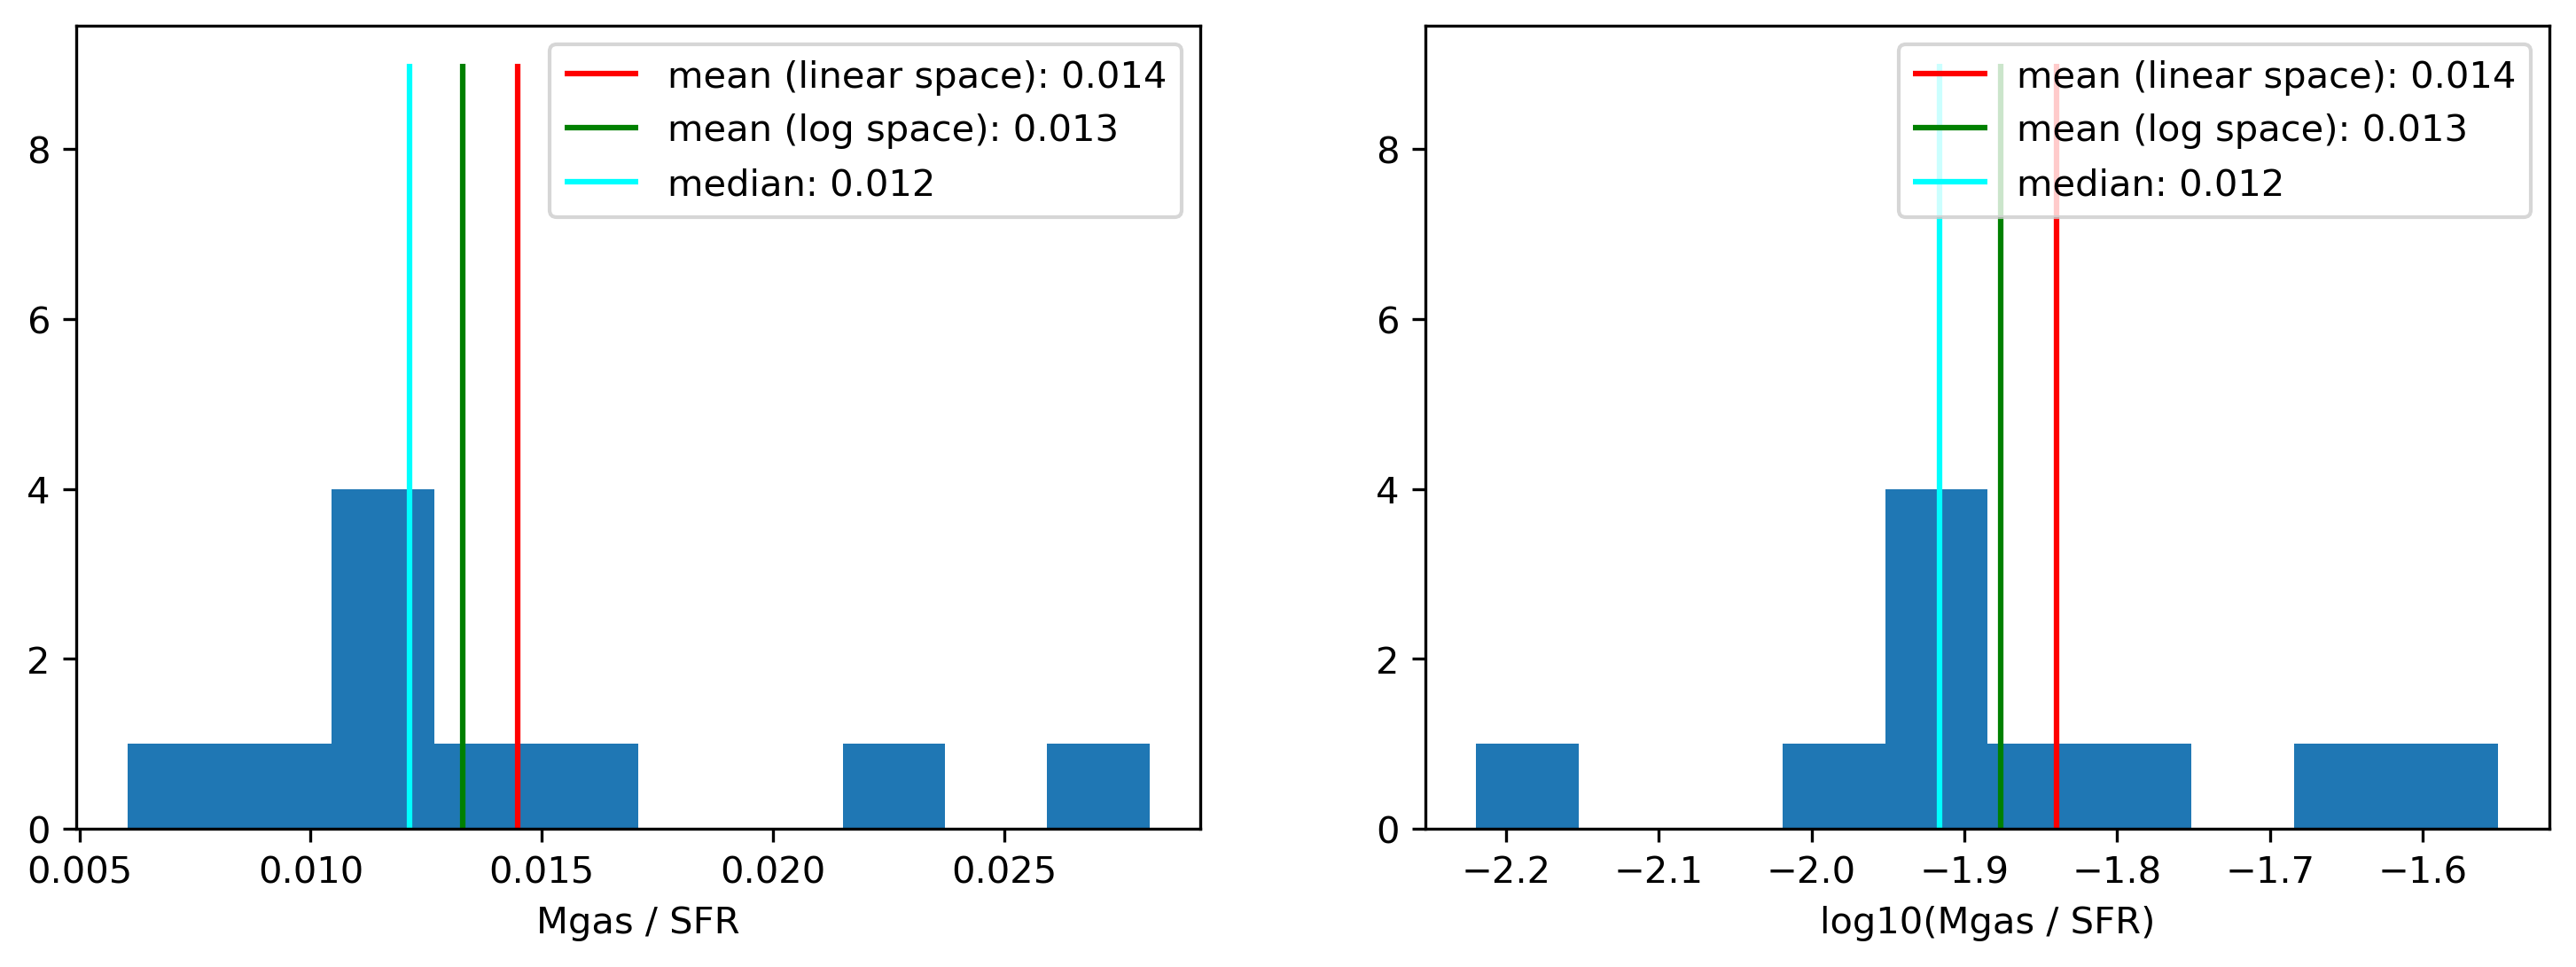

In [18]:
plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.hist(x)
plt.xlabel('Mgas / SFR')
plt.vlines((x.mean()), 0, 9, color='red', label='mean (linear space): {:.3f}'.format(x.mean()))
plt.vlines(10**(np.log10(x).mean()), 0, 9, color='green', label='mean (log space): {:.3f}'.format(10**(np.log10(x).mean())))
plt.vlines((x.median()), 0, 9, color='cyan', label='median: {:.3f}'.format(x.median()))
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.log10(x))
plt.xlabel('log10(Mgas / SFR)')
plt.vlines(np.log10(x.mean()), 0, 9, color='red', label='mean (linear space): {:.3f}'.format(x.mean()))
plt.vlines((np.log10(x).mean()), 0, 9, color='green', label='mean (log space): {:.3f}'.format(10**(np.log10(x).mean())))
plt.vlines(np.log10(x.median()), 0, 9, color='cyan', label='median: {:.3f}'.format(x.median()))
plt.legend()

These histograms compare the final gas masses calculated above to the SFRs reported by Hill. It seems reasonable to adopt a scale fractor of Mgas / SFR = 0.017, the mean ratio in log space. This looks to be good within half an order of magnitude.

In [19]:
ratio_Mgas_SFR = 0.013

### Compute SFRs and gas masses of LAEs

Apostolovski reports that the Lyman alpha blob has an SFR of 7 M☉ per year and a flux of 3663.02 erg s^-1 cm^-2. This results in a conversion factor of:

In [20]:
ratio_SFR_FLya = 7. / 3663.02
ratio_SFR_FLya

0.0019109914769780128

In [21]:
# compute SFRs for LAEs
df['Apostolovski', 'SFR'] = ratio_SFR_FLya * df['Apostolovski', 'FLya']
# convert this to a gass mass using the conversion factor above
df['Apostolovski', 'Mgas'] = ratio_Mgas_SFR * df['Apostolovski', 'SFR']
# let's look at what we've got
df['Apostolovski'].loc[df['Apostolovski', 'Mgas'].notna(), :]

,FLya,u_FLya,RA,DEC,v,u_v,SFR,Mgas
label,,,,,,,,
LAE-ID72,2216.32,282.50,23:49:42.18,-56:38:10.48,241.53,5.16,4.235369,0.055060
LAE-ID21,514.19,145.61,23:49:41.28,-56:37:58.2,67.28,8.76,0.982613,0.012774
LAE-ID56,191.66,166.20,23:49:44.26,-56:38:40.9,905.95,22.35,0.366261,0.004761
LAE-ID109,239.70,170.69,23:49:39.90,-56:38:12.22,532.33,22.48,0.458065,0.005955
LAE-ID74,366.35,243.59,23:49:43.47,-56:37:02.37,170.40,21.74,0.700092,0.009101
LAE-ID91,329.25,196.04,23:49:40.96,-56:37:09.18,836.04,19.08,0.629194,0.008180
LAE-ID118,320.75,216.14,23:49:45.41,-56:37:28.70,879.51,11.96,0.612951,0.007968


### Gas masses of LBGs
We already have SFRs of the LBGs. We use to this same conversion factor to convert to gas masses.

In [22]:
df['Rotermund_2021', 'Mgas'] = ratio_Mgas_SFR * df['Rotermund_2021', 'SFR']

### Add to list of "final" gas masses

In [23]:
# add these gas masses to the list of final masses
df['final', 'Mgas'], df['final', 'Mgas_method'], df['final', 'Mgas_source'] = multiwhereswitch(
    df['final', 'Mgas_method'].notna(), # keep existing values first
    [df['final', 'Mgas'], df['final', 'Mgas_method'], df['final', 'Mgas_source']],
    
    # condition: SFR from Rotermund but not Apostolovski
    df['Rotermund_2021', 'Mgas'].notna() & df['Apostolovski', 'Mgas'].isna(),
    [
        df['Rotermund_2021', 'Mgas'], # gas masses
        'SFR', # method
        'Rotermund_2021' # source
    ],
    
    # condition: SFR from Apostolovski but not Rotermund
    df['Rotermund_2021', 'Mgas'].isna() & df['Apostolovski', 'Mgas'].notna(),
    [
        df['Apostolovski', 'Mgas'], # gas masses
        'SFR', # method
        'Apostolovski' # source
    ],
    
    # condition: SFR from both Apostolovski and Rotermund: use mean gas mass from both
    df['Rotermund_2021', 'Mgas'].notna() & df['Apostolovski', 'Mgas'].notna(),
    [
        (df['Rotermund_2021', 'Mgas']+df['Apostolovski', 'Mgas'])/2, # gas masses
        'SFR', # method
        'Rotermund_2021|Apostolovski' # source
    ],
    
    force_object=[False, True, True]) # force object dtype when we deal with strings


# 3. Stellar masses

Where Hill (2021) has good estimates of stellar mass, we use these, and otherwise we use Doug's conversion factor to compute stellar masses from gas masses.

In [24]:
# scale factor: ratio of stellar mass to gas mass

# assumed gas mass fraction - as per Rennehan et al. 2020
# gas mass / (gas mass + stellar mass)
fgas = 0.7
fgas_C1 = 0.7
# fgas_C1 = 0.4
# Originally we used a gas fraction of 0.4 for C1 on the ratinale that the error in Hill+ 2021's stellar
# mass measurement is due to the foreground object, not due to lots of gas as in the other galaxies. We
# no longer think this is a good assumption, so now we use a gas fraction of 0.7 as in the other galaxies.


ratio_stellar_gas = 1/fgas - 1 # derived in Rennehan et al. 2020
ratio_stellar_gas_C1 = 1/fgas_C1 - 1

ratio_stellar_gas, ratio_stellar_gas_C1

(0.4285714285714286, 0.4285714285714286)

In [25]:
# add column for stellar mass based on scale factor
df['derived', 'M*_scale'] = ratio_stellar_gas * df['final', 'Mgas']

In [26]:
# the maximum fractional uncertainty we allow in Hill's stellar masses
# stellar masses with more than this uncertainty will be rejected;
# we'll use Doug's conversion factor for those galaxies
max_stellar_pu = 0.6

In [27]:
# compute stellar mass
# use Hill's estimates where Hill had little uncertainty, use scale factor otherwise
df['final', 'M*'], df['final', 'M*_method'], df['final', 'M*_source'] = multiwhereswitch(
    # condition: fractional uncertainty small
    df['Hill_2021', 'pu_M*'] <= max_stellar_pu,
    [
        df['Hill_2021', 'M*'], # gas masses
        'SEDfit', # method
        'Hill_2021' # data source
    ],
    
    # condition: source C1 (it gets special scale factor)
    df.index.values == 'C1',
    [
        ratio_stellar_gas_C1 * df.loc['C1', ('final', 'Mgas')],
        'fgas={:.1f}'.format(fgas_C1), # method
        'Hill_2020' # data source
    ],
    
    # condition: we have a value computed based on fgas=0.7
    df['derived', 'M*_scale'].notna(),
    [
        df['derived', 'M*_scale'], # gas masses
        'fgas={:.1f}'.format(fgas_C1), # method
        df['final', 'Mgas_source'] # source
    ],
)

# check that we have M* results for all galaxies
#assert(all(df['final', 'M*'].notna()))

# 4. Halo masses

We follow Rennehan 2018 in assuming Mvir = 100 M*, where Mvir is the virulent mass of the dark matter halo.

In [28]:
# ratio_halo_stellar = 100.
# df['final', 'Mvir'] = ratio_halo_stellar * df['final', 'M*']

fdisk = 0.03 # (gas mass + stellar mass)/(gas mass + stellar mass + halo mass)
df['final', 'Mvir'] = (1/fdisk - 1) * (df['final', 'Mgas'] + df['final', 'M*'])

In [29]:
# add column with total mass
df['final', 'M'] = df['final', 'Mgas'] + df['final', 'M*'] + df['final', 'Mvir']

# 5. Gas and disk fractions

Let's add data for the gas fractions $f_{gas} = \frac{M_{gas}}{M_{gas} + M_*}$
and the disk fractions $f_{disk} = \frac{M_{gas} + M_{stars}}{M_{gas} + M_{stars} + M_{halo}}$.

$\frac{M_{halo}}{M_{stars}}$ is also an interesting quantity.

In [30]:
# compute gas fraction
df['final', 'fgas'] = df['final', 'Mgas'] / (df['final', 'Mgas'] + df['final', 'M*'])
# compute disk fraction
df['final', 'fdisk'] = (df['final', 'Mgas'] + df['final', 'M*']) / df['final', 'M']
# compute Mvir/M*
df['final', 'Mvir/M*'] = df['final', 'Mvir'] / df['final', 'M*']

# 6. Add positions and velocities to "final"

In [31]:
# position coordinates
df['final', 'RA'], df['final', 'DEC'] = multiwhereswitch(
    # condition: coordinates from Rotermund+ (more decimal places than Hill+ 2020)
    df['Rotermund_2021', 'RA'].notna(),
    [
        df['Rotermund_2021', 'RA'],
        df['Rotermund_2021', 'DEC']
    ],
    # condition: coordiantes from Hill+ 2020
    df['Hill_2020', 'RA'].notna(),
    [
        df['Hill_2020', 'RA'],
        df['Hill_2020', 'DEC']
    ],
    # condition: coordinates from Apostolovski
    df['Apostolovski', 'RA'].notna(),
    [
        df['Apostolovski', 'RA'],
        df['Apostolovski', 'DEC']
    ],
    # condition: coordinates from Nik
    df['Nik', 'RA'].notna(),
    [
        df['Nik', 'RA'],
        df['Nik', 'DEC']
    ]
)

# velocities relative to protocluster centre
df['final', 'v'], df['final', 'u_v'] = multiwhereswitch(
    # condition: velocity from Hill+ 2020
    df['Hill_2020', 'v'].notna(),
    [
        df['Hill_2020', 'v'],
        df['Hill_2020', 'u_v']
    ],
    # condition: velocity from Nik
    df['Nik', 'v'].notna(),
    [
        df['Nik', 'v'],
        df['Nik', 'u_v']
    ],
    # condition: velocity from Apostolovski+
    df['Apostolovski', 'v'].notna(),
    [
        df['Apostolovski', 'v'],
        df['Apostolovski', 'u_v']
    ]
)

# 7. Compute distance of each galaxy from the centre

In [32]:
# add column with the distance from the centre of mass

# conversion factor from arcsec to kpc
ratio_kpc_arcsec = 7.
# galaxies within 95 kpc of C20 will be included in the centre of mass calculation
centre_radius = 95
centre = 'C20'

# use SkyCoord class to parse the strings with ra and dec
c = SkyCoord(ra=df['final', 'RA'], dec=df['final', 'DEC'],
             unit=(u.hourangle, u.deg))

# get galaxy coordinates in arcsec
ra, dec = c.ra.arcsec, c.dec.arcsec

# find ra, dec coordinates of galaxy to use as temporary centre
centre_ra = ra[(df.index.values == centre)]
centre_dec = dec[(df.index.values == centre)]

# compute coordinates in kiloparsecs
x = ratio_kpc_arcsec * (ra - centre_ra) * np.cos(c.dec.radian) # position north-south
# the cosine accounts for the lines of declination getting shorter the larger the declination
y = ratio_kpc_arcsec * (dec - centre_dec) # position east-west

# determine which galaxies are within centre_radius of the galaxy called centre
l = np.sqrt(x**2 + y**2) < centre_radius

M = df['final', 'M']
# compute centre of mass of region within this radius using weighted average
cmass_x, cmass_y = (x[l] * M[l]).sum() / M[l].sum(), (y[l] * M[l]).sum() / M[l].sum()
# change coordrinates so that centre of mass is at (0, 0)
x, y = x - cmass_x, y - cmass_y

# compute distance of each galaxy from the centre of mass in kpc
df['final', 'r'] = np.sqrt(x**2 + y**2)

# 8. Save table of results to fixed-width txt file

In [33]:
# here's what we will save
df['final']

,Mgas,Mgas_method,Mgas_source,M*,M*_method,M*_source,Mvir,M,fgas,fdisk,Mvir/M*,RA,DEC,v,u_v,r
label,,,,,,,,,,,,,,,,
C1,16.460824,CO43,Hill_2020,7.054639,fgas=0.7,Hill_2020,760.333287,783.848749,0.700000,0.03,107.777778,23:49:42.65,−56:38:19.4,15.00,4.00,30.403785
C2,4.609031,CO43,Hill_2020,6.500000,SEDfit,Hill_2021,359.191991,370.301022,0.414890,0.03,55.260306,23:49:43.25,−56:38:30.1,-544.00,2.00,61.412221
C3,9.437539,CO43,Hill_2020,4.044660,fgas=0.7,Hill_2020,435.924418,449.406616,0.700000,0.03,107.777778,23:49:42.78,−56:38:23.8,-86.00,11.00,14.402928
C4,6.584329,CO43,Hill_2020,2.821855,fgas=0.7,Hill_2020,304.133315,313.539500,0.700000,0.03,107.777778,23:49:41.41,−56:38:22.5,-83.00,13.00,65.231556
C5,2.414254,CO43,Hill_2020,1.034680,fgas=0.7,Hill_2020,111.515549,114.964483,0.700000,0.03,107.777778,23:49:42.13,−56:38:25.8,235.00,6.00,27.703426
C6,7.462240,CO43,Hill_2020,13.900000,SEDfit,Hill_2021,690.712430,712.074670,0.349319,0.03,49.691542,23:49:42.84,−56:38:25.1,471.00,3.00,20.570364
C7,2.194776,CO43,Hill_2020,0.940618,fgas=0.7,Hill_2020,101.377772,104.513167,0.700000,0.03,107.777778,23:49:42.96,−56:38:18.1,631.00,3.00,45.955921
C8,5.267464,CO43,Hill_2020,5.000000,SEDfit,Hill_2021,331.981323,342.248786,0.513025,0.03,66.396265,23:49:41.22,−56:38:24.6,-22.00,4.00,76.021075
C9,1.975299,CO43,Hill_2020,0.846557,fgas=0.7,Hill_2020,91.239994,94.061850,0.700000,0.03,107.777778,23:49:42.22,−56:38:28.1,153.00,6.00,36.077008


In [34]:
# save the data
df['final'].reset_index().to_string('galaxy_masses.txt', index=False)
# save another file with just the galaxies within 95 kpc of the centre
df.loc[df['final', 'r']<95, 'final'].reset_index().to_string('galaxy_masses_95.txt', index=False)